In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import warnings
import math
from typing import Dict, Union, Tuple, Any, List

In [3]:
# 1. Data Generation

def generate_imbalanced_data(n_samples=1000, noise_level=0.01):
    """
    Generates a 2D imbalanced dataset for binary classification.
    The decision boundary is linear (x1 - 2*x2 = 0).
    """
    X = np.random.randn(n_samples, 2).astype(np.float32)
    decision_boundary = X[:, 0] - 2 * X[:, 1]
    noise = noise_level * np.random.randn(n_samples)
    y = (decision_boundary + noise > 0).astype(np.float32)
    
    # Create imbalance
    minority_class_indices = np.where(y == 1)[0]
    majority_class_indices = np.where(y == 0)[0]
    
    # Intentionally create a small dataset to highlight model differences
    n_minority = int(n_samples / 4 * 0.1) # e.g., 12
    n_majority = int(n_samples / 4 * 0.9) # e.g., 108
    
    if len(minority_class_indices) < n_minority or len(majority_class_indices) < n_majority:
        warnings.warn("Not enough samples to create the desired imbalance. Using all available.")
        n_minority = min(n_minority, len(minority_class_indices))
        n_majority = min(n_majority, len(majority_class_indices))

    selected_minority = np.random.choice(minority_class_indices, n_minority, replace=False)
    selected_majority = np.random.choice(majority_class_indices, n_majority, replace=False)
    
    selected_indices = np.concatenate([selected_minority, selected_majority])
    np.random.shuffle(selected_indices)
    
    return X[selected_indices], y[selected_indices]

def generate_balanced_data(n_samples=1000, noise_level=0.1):
    """
    Generates a 2D balanced dataset for binary classification.
    """
    X = np.random.randn(n_samples, 2).astype(np.float32)
    decision_boundary = X[:, 0] - 2 * X[:, 1]
    noise = noise_level * np.random.randn(n_samples)
    y = (decision_boundary + noise > 0).astype(np.float32)
    return X, y

In [4]:
# 2. Core Modules and Base Classes

class DROError(Exception):
    """Base exception class for custom DRO models."""
    pass

class LinearModel(nn.Module):
    """
    PyTorch Linear Model for regression or classification tasks.
    """
    def __init__(self, input_dim: int, output_dim: int = 1, bias: bool = True):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the linear model."""
        return self.linear(x)

class BaseLinearDRO:
    """A minimal base class for structure and type hinting."""
    def __init__(self, input_dim: int, model_type: str, fit_intercept: bool):
        self.input_dim = input_dim
        self.model_type = model_type.lower()
        self.fit_intercept = fit_intercept

    def _to_tensor(self, data: np.ndarray) -> torch.Tensor:
        """Convert numpy array to a tensor on the correct device."""
        return torch.as_tensor(data, dtype=torch.float32, device=self.device)

    def _validate_inputs(self, X: np.ndarray, y: np.ndarray) -> None:
        """Validate input dimensions."""
        if X.ndim == 1: X = X.reshape(-1, self.input_dim)
        if y.ndim == 1: y = y.reshape(-1, 1)
        if X.shape[0] != y.shape[0]:
            raise DROError(f"X and y must have the same number of samples. Got X: {X.shape[0]}, y: {y.shape[0]}")
        if X.shape[1] != self.input_dim:
            raise DROError(f"Expected input_dim={self.input_dim} features for X, got {X.shape[1]}")

    def _create_dataloader(self, X: np.ndarray, y: np.ndarray, batch_size: int) -> DataLoader:
        """Create a PyTorch DataLoader from numpy data."""
        X_tensor = self._to_tensor(X)
        y_tensor = self._to_tensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    def _extract_parameters(self) -> Dict[str, np.ndarray | None]:
        """Extract model parameters as numpy arrays."""
        theta = self.model.linear.weight.detach().cpu().numpy().flatten()
        bias_val = None
        if self.model.linear.bias is not None:
            bias_val = self.model.linear.bias.detach().cpu().numpy()
        return {"theta": theta, "bias": bias_val}

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Generate raw model predictions (logits)."""
        # A dummy y is created for validation, it is not used.
        self._validate_inputs(X, np.zeros(X.shape[0]))
        X_tensor = self._to_tensor(X)
        self.model.eval()
        with torch.no_grad():
            predictions_logits = self.model(X_tensor).cpu().numpy()
        return predictions_logits

    def score(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        """Evaluate model performance on given data."""
        y_pred_logits = self.predict(X) 
        y_true_flat = y.flatten()
        pred_labels_flat = (y_pred_logits.flatten() >= 0).astype(int)
        accuracy = accuracy_score(y_true_flat, pred_labels_flat)
        f1 = f1_score(y_true_flat, pred_labels_flat, average='macro', zero_division=0)
        return accuracy, f1

In [5]:
# 3. Model Implementation

class SinkhornLinearDRO(BaseLinearDRO):
    """Sinkhorn Distributionally Robust Optimization with Linear Models."""
    def __init__(self,
                input_dim: int,
                fit_intercept: bool = True, 
                reg_param: float = 1e-3,
                lambda_param: float = 1e2,
                max_iter: int = 1000,
                learning_rate: float = 1e-2,
                k_sample_max: int = 5,
                device: str = "cpu"):
        super().__init__(input_dim, "logistic", fit_intercept)
        self.reg_param = reg_param
        self.lambda_param = lambda_param
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.k_sample_max = k_sample_max
        self.device = torch.device(device if device == "cuda" and torch.cuda.is_available() else "cpu")
        self.model = LinearModel(input_dim, output_dim=1, bias=fit_intercept).to(self.device)

    def _compute_loss(self, predictions, targets, m, lambda_reg):
        """Computes the Sinkhorn loss."""
        criterion = nn.BCEWithLogitsLoss(reduction='none')
        residuals = criterion(predictions, targets) / lambda_reg
        residual_matrix = residuals.view(m, -1)
        return torch.mean(torch.logsumexp(residual_matrix, dim=0) - math.log(m)) * lambda_reg

    def fit(self, X: np.ndarray, y: np.ndarray) -> Tuple[Dict[str, np.ndarray], List[float]]:
        """Train the model using standard SGD and return loss history."""
        self._validate_inputs(X, y)
        dataloader = self._create_dataloader(X, y.reshape(-1,1), batch_size=1)
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        lambda_reg = self.lambda_param * self.reg_param
        
        loss_history = []
        self.model.train()
        for epoch in range(self.max_iter):
            for data, target in dataloader:
                optimizer.zero_grad()

                # Fixed number of samples for SGD
                m = 2 ** self.k_sample_max
                
                expanded_data = data.repeat(m, 1)
                noise = torch.randn_like(expanded_data) * math.sqrt(self.reg_param)
                noisy_data = expanded_data + noise
                repeated_target = target.repeat(m, 1)

                predictions = self.model(noisy_data)
                loss = self._compute_loss(predictions, repeated_target, m, lambda_reg)
                
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())

        return self._extract_parameters(), loss_history

class AdjustedSteinTransport:
    """Implements Adjusted Stein Transport using a Gaussian RBF kernel."""
    def __init__(self, lam=1e-2, n_steps=50, n_svgd=1, dt=0.02, dt_svgd=0.02, clip_value=1e4):
        self.lam = lam
        self.n_steps = n_steps
        self.n_svgd = n_svgd
        self.dt = dt
        self.dt_svgd = dt_svgd
        # Add a clipping value to prevent gradient explosion
        self.clip_value = clip_value

    def _rbf_kernel(self, X):
        """Computes the Gaussian RBF kernel and its derivatives."""
        N, D = X.shape
        pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))
        # Add a small epsilon to h2 to avoid division by zero
        h2 = 0.5 * np.median(pairwise_sq_dists) / np.log(N + 1)
        h2 = np.max([h2, 1e-6]) 
        K = np.exp(-pairwise_sq_dists / (2 * h2))
        X_diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
        grad_K_x = -X_diff / h2 * K[..., np.newaxis]
        grad_K_y = X_diff / h2 * K[..., np.newaxis]
        trace_H = (D / h2 - pairwise_sq_dists / h2**2) * K
        return K, grad_K_x, grad_K_y, trace_H

    def update(self, X0, grad_log_prior, neg_log_likelihood, grad_neg_log_likelihood):
        """Executes the full Adjusted Stein Transport algorithm."""
        X = np.copy(X0)
        N, _ = X.shape

        for n in range(self.n_steps):
            t_n = n * self.dt
            grad_log_pi_t = lambda x: grad_log_prior(x) - t_n * grad_neg_log_likelihood(x)
            
            # --- SVGD Adjustment Step ---
            for _ in range(self.n_svgd):
                P_svgd = grad_log_pi_t(X)
                # Clip gradients to prevent explosion
                np.clip(P_svgd, -self.clip_value, self.clip_value, out=P_svgd)
                K_svgd, _, grad_K_y_svgd, _ = self._rbf_kernel(X)
                svgd_grad = (K_svgd @ P_svgd + np.sum(grad_K_y_svgd, axis=1)) / N
                X += self.dt_svgd * svgd_grad

            # --- Main Stein Transport Step ---
            P_transport = grad_log_pi_t(X)
            # FIX: Clip the gradients to prevent overflow in the subsequent matmul
            np.clip(P_transport, -self.clip_value, self.clip_value, out=P_transport)
            
            K, grad_K_x, grad_K_y, trace_H = self._rbf_kernel(X)
            term1 = np.einsum('id,ijd->ij', P_transport, grad_K_y)
            term2 = np.einsum('jd,ijd->ij', P_transport, grad_K_x)
            term3 = (P_transport @ P_transport.T) * K
            xi_matrix = term1 + term2 + term3 + trace_H
            h_vec = neg_log_likelihood(X).flatten()
            h_centered = h_vec - np.mean(h_vec)
            A = xi_matrix / N + self.lam * np.identity(N)
            
            try:
                phi_weights = np.linalg.solve(A, h_centered)
            except np.linalg.LinAlgError:
                # If solver fails, use pseudo-inverse as a fallback
                warnings.warn("Linear solver failed. Using pseudo-inverse.")
                phi_weights = np.linalg.pinv(A) @ h_centered
                
            term_a = (K * phi_weights[np.newaxis, :]) @ P_transport
            term_b = np.einsum('j,ijd->id', phi_weights, grad_K_y)
            transport_grad = (term_a + term_b) / N
            X += self.dt * transport_grad
            
        return X

class SinkhornDROLogisticAST(BaseLinearDRO):
    """Sinkhorn DRO for Logistic Regression using Adjusted Stein Transport (AST)."""
    def __init__(self,
                 input_dim: int,
                 fit_intercept: bool = True,
                 epsilon: float = 0.1,
                 lambda_dro: float = 1.0,
                 ast_lam: float = 1,
                 ast_n_steps: int = 20,
                 ast_n_svgd: int = 1,
                 num_ast_samples: int = 10,
                 max_iter: int = 100,
                 learning_rate: float = 0.01,
                 device: str = "cpu"):
        super().__init__(input_dim, "logistic", fit_intercept)
        self.epsilon = epsilon
        self.lambda_dro = lambda_dro
        # Pass a clipping value to the AST constructor
        self.ast_params = {'lam': ast_lam, 'n_steps': ast_n_steps, 'n_svgd': ast_n_svgd, 
                           'dt': 1/ast_n_steps, 'dt_svgd': 1/ast_n_steps/ast_n_svgd,
                           'clip_value': 1e4}
        self.num_ast_samples = num_ast_samples
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.device = torch.device(device if device == "cuda" and torch.cuda.is_available() else "cpu")
        self.model = LinearModel(self.input_dim, output_dim=1, bias=self.fit_intercept).to(self.device)

    def _ast_sampler(self, x_orig, y_orig, model):
        """Generates worst-case samples using the AST algorithm."""
        ast = AdjustedSteinTransport(**self.ast_params)
        
        def grad_log_prior(x_np):
            return -2.0 / self.epsilon * (x_np - x_orig.cpu().numpy())

        def neg_log_likelihood(x_np):
            x_torch = self._to_tensor(x_np)
            # Handle cases where x_np has fewer samples than y_orig expects
            num_samples = x_torch.shape[0]
            y_torch = y_orig.repeat(num_samples, 1)
            predictions = model(x_torch)
            loss = nn.BCEWithLogitsLoss(reduction='none')(predictions, y_torch)
            return (-loss / (self.lambda_dro * self.epsilon)).detach().cpu().numpy().flatten()

        def grad_neg_log_likelihood(x_np):
            x_torch = self._to_tensor(x_np).requires_grad_(True)
            num_samples = x_torch.shape[0]
            y_torch = y_orig.repeat(num_samples, 1)
            predictions = model(x_torch)
            # Use sum reduction for scalar output needed by autograd
            f_x_theta = nn.BCEWithLogitsLoss(reduction='sum')(predictions, y_torch)
            grad_f = torch.autograd.grad(f_x_theta, x_torch, retain_graph=True)[0]
            return (-grad_f / (self.lambda_dro * self.epsilon)).detach().cpu().numpy()

        mean = x_orig
        std_dev = torch.sqrt(torch.tensor(self.epsilon / 2.0, device=self.device))
        X0_torch = mean + std_dev * torch.randn(self.num_ast_samples, self.input_dim, device=self.device)
        
        final_particles_np = ast.update(
            X0_torch.cpu().numpy(), 
            grad_log_prior, neg_log_likelihood, 
            grad_neg_log_likelihood
        )
        return self._to_tensor(final_particles_np)

    def fit(self, X, y) -> Tuple[Dict[str, np.ndarray], List[float]]:
        """Train the model and return loss history."""
        self._validate_inputs(X, y)
        dataloader = self._create_dataloader(X, y.reshape(-1,1), batch_size=1)
        optimizer_theta = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        loss_history = []
        self.model.train()
        for epoch in range(self.max_iter):
            for x_orig, y_orig in dataloader:
                # Detach the model from the graph for the sampler to avoid nested autograd issues
                self.model.eval()
                worst_case_samples = self._ast_sampler(x_orig, y_orig, self.model)
                self.model.train()

                y_repeated = y_orig.repeat(self.num_ast_samples, 1)
                predictions = self.model(worst_case_samples)
                loss = nn.BCEWithLogitsLoss()(predictions, y_repeated)
                
                optimizer_theta.zero_grad()
                loss.backward()
                optimizer_theta.step()
                loss_history.append(loss.item())
        return self._extract_parameters(), loss_history

In [6]:
# 4. Analysis and Plotting

def analyze_decision_boundary(params, X, y, title):
    """Prints analysis of a model's decision boundary."""
    theta = np.array(params['theta'])
    bias = params['bias'].item() if hasattr(params['bias'], 'item') and params['bias'] is not None else 0.0
    
    print(f"\n--- {title} Analysis ---")
    print(f"Model parameters: theta=[{theta[0]:.4f}, {theta[1]:.4f}], bias={bias:.4f}")
    
    logits = X @ theta + bias
    preds = (logits >= 0).astype(np.float32)
    distances = np.abs(logits)
    near_boundary = distances < 0.1
    
    print(f"Fraction of test samples near boundary: {np.mean(near_boundary):.2%}")
    acc, f1 = accuracy_score(y, preds), f1_score(y, preds)
    print(f"Accuracy on test set: {acc:.4f}, F1-Score: {f1:.4f}")

def plot_decision_boundaries(X_train, y_train, params_dict, iteration):
    """Plots data and decision boundaries for multiple models."""
    plt.figure(figsize=(12, 9))
    
    # Plot training data points
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
                c='royalblue', marker='o', label='Training Negative', alpha=0.7, edgecolors='w')
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='crimson', marker='^', label='Training Positive', alpha=0.7, edgecolors='w')
    
    # Generate grid for plotting boundaries
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, 200)

    # Define styles for plotting
    styles = {'Sinkhorn': ('g', '-', 'Sinkhorn'), 
              'AST': ('purple', ':', 'AST')}

    for name, params in params_dict.items():
        if params is not None:
            theta = np.array(params['theta'])
            bias = params['bias'].item() if hasattr(params['bias'], 'item') and params['bias'] is not None else 0.0
            
            if abs(theta[1]) > 1e-6:
                yy = -(theta[0] * xx + bias) / theta[1]
                color, style, label = styles[name]
                plt.plot(xx, yy, color=color, linestyle=style, linewidth=2.5,
                         label=f'{label} (θ=[{theta[0]:.2f},{theta[1]:.2f}],b={bias:.2f})')
    
    # Plot true decision boundary: x1 - 2*x2 = 0  => x2 = 0.5 * x1
    yy_true = 0.5 * xx
    plt.plot(xx, yy_true, 'k-', linewidth=2, label='True Boundary')
    
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(f"Decision Boundaries (Experiment {iteration+1}, N_train={len(X_train)})", fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'decision_boundaries_exp_{iteration+1}.png', dpi=300)
    plt.close()

def plot_loss_convergence(loss_histories, iteration):
    """Plots the convergence of the objective function for different models."""
    plt.figure(figsize=(12, 8))
    
    styles = {'Sinkhorn': ('g', '-'), 'AST': ('purple', ':')}
    
    for name, history in loss_histories.items():
        if history:
            color, style = styles[name]
            # Use a moving average to smooth the curve for better visualization
            window_size = len(history) // 20
            if window_size > 0:
                moving_avg = np.convolve(history, np.ones(window_size)/window_size, mode='valid')
                plt.plot(moving_avg, color=color, linestyle=style, label=f'{name} (Smoothed)')
            else:
                plt.plot(history, color=color, linestyle=style, label=name)

    plt.xlabel('Training Step (Theta Update)', fontsize=12)
    plt.ylabel('Loss Value', fontsize=12)
    plt.title(f'Loss Convergence (Experiment {iteration+1})', fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.yscale('log') # Use log scale for better visualization of convergence
    plt.tight_layout()
    plt.show()
    plt.savefig(f'loss_convergence_exp_{iteration+1}.png', dpi=300)
    plt.close()



Running all experiments on device: '0'

==================== Experiment 1/5 ====================
Training data: 124 samples (9.7% positive)
Test data: 2000 samples

Training Sinkhorn DRO (SGD)...
Sinkhorn DRO Final F1-Score: 0.8997

Training AST Sampler DRO...
AST DRO Final F1-Score: 0.9047

--- Sinkhorn Analysis ---
Model parameters: theta=[5.1626, -7.4302], bias=-2.1727
Fraction of test samples near boundary: 0.75%
Accuracy on test set: 0.9000, F1-Score: 0.8938

--- AST Analysis ---
Model parameters: theta=[5.2213, -7.7800], bias=-2.1418
Fraction of test samples near boundary: 0.95%
Accuracy on test set: 0.9050, F1-Score: 0.8996

==================== Experiment 2/5 ====================
Training data: 124 samples (9.7% positive)
Test data: 2000 samples

Training Sinkhorn DRO (SGD)...
Sinkhorn DRO Final F1-Score: 0.9146

Training AST Sampler DRO...
AST DRO Final F1-Score: 0.9172

--- Sinkhorn Analysis ---
Model parameters: theta=[3.4257, -6.9202], bias=-1.5225
Fraction of test samples

/tmp/ipykernel_3268764/4120321280.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(scores.values()), labels=list(scores.keys()), patch_artist=True,


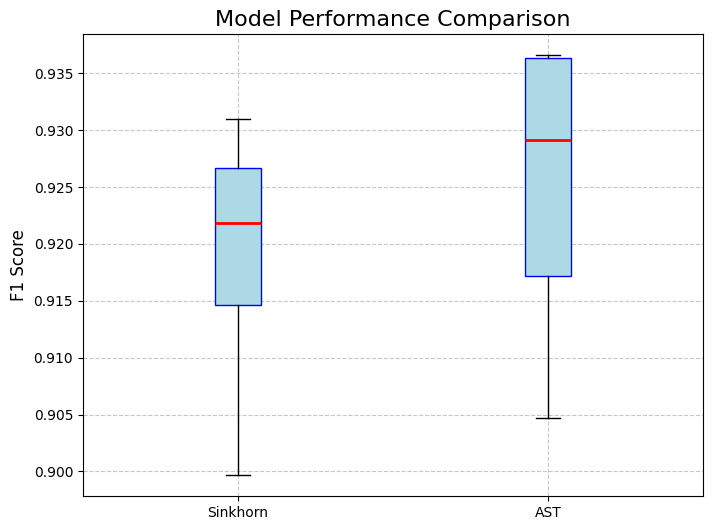

In [14]:
# 5. Run Experiments
def run_comparison_experiment(loops=10):
    """
    Runs a full comparison between Sinkhorn DRO (SGD) and AST models.
    """
    scores = {'Sinkhorn': [], 'AST': []}
    
    device = "0"
    print(f"\nRunning all experiments on device: '{device}'")

    for i in range(loops):
        print(f"\n{'='*20} Experiment {i+1}/{loops} {'='*20}")
        
        # Generate data
        X_train, y_train = generate_imbalanced_data(n_samples=500, noise_level=0.1)
        X_test, y_test = generate_balanced_data(n_samples=2000, noise_level=0.1)
        print(f"Training data: {len(X_train)} samples ({np.mean(y_train):.1%} positive)")
        print(f"Test data: {len(X_test)} samples")

        params_dict = {'Sinkhorn': None, 'AST': None}
        loss_histories = {'Sinkhorn': [], 'AST': []}

        # --- Train and Evaluate Sinkhorn DRO ---
        print("\nTraining Sinkhorn DRO (SGD)...")
        try:
            model_sdro = SinkhornLinearDRO(
                input_dim=2, reg_param=1e-2, lambda_param=100.0,
                max_iter=50, learning_rate=1e-2, k_sample_max=3, device=device
            )
            params_dict['Sinkhorn'], loss_histories['Sinkhorn'] = model_sdro.fit(X_train, y_train)
            _, f1 = model_sdro.score(X_test, y_test)
            scores['Sinkhorn'].append(f1)
            print(f"Sinkhorn DRO Final F1-Score: {f1:.4f}")
        except Exception as e:
            print(f"Sinkhorn DRO training failed: {e}")
            scores['Sinkhorn'].append(0)

        # --- Train and Evaluate AST ---
        print("\nTraining AST Sampler DRO...")
        try:
            model_ast = SinkhornDROLogisticAST(
                input_dim=2, epsilon=0.01, lambda_dro=100.0, 
                ast_n_steps=50, ast_n_svgd=1, num_ast_samples=8,
                max_iter=50, learning_rate=0.01, device=device
            )
            params_dict['AST'], loss_histories['AST'] = model_ast.fit(X_train, y_train)
            _, f1 = model_ast.score(X_test, y_test)
            scores['AST'].append(f1)
            print(f"AST DRO Final F1-Score: {f1:.4f}")
        except Exception as e:
            print(f"AST training failed: {e}")
            scores['AST'].append(0)

        # Analyze and plot boundaries for the current experiment
        for name, params in params_dict.items():
            if params:
                analyze_decision_boundary(params, X_test, y_test, name)
        plot_decision_boundaries(X_train, y_train, params_dict, i)
        
        # Plot loss convergence for the current experiment
        plot_loss_convergence(loss_histories, i)


    # --- Final Results ---
    print(f"\n{'='*25} Final Results over {loops} Experiments {'='*25}")
    for name, f1_scores in scores.items():
        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        print(f"{name} Average F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
    
    # Plot final performance comparison
    plt.figure(figsize=(8, 6))
    plt.boxplot(list(scores.values()), labels=list(scores.keys()), patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))
    plt.title('Model Performance Comparison', fontsize=16)
    plt.ylabel('F1 Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    plt.savefig('final_performance_comparison.png', dpi=300)
    plt.close()

run_comparison_experiment(loops=5)